In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

from model import EarthVisionModel

In [16]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        _dict = pickle.load(fo, encoding='bytes')
    return _dict

label_meta = unpickle("./meta")

In [11]:
flag = np.zeros((32,256))

In [28]:
'''
Modified from https://raw.githubusercontent.com/pytorch/vision/v0.9.1/torchvision/models/mobilenetv2.py

BSD 3-Clause License

Copyright (c) Soumith Chintala 2016,
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of the copyright holder nor the names of its
  contributors may be used to endorse or promote products derived from
  this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
'''
import sys
import torch
from torch import nn
from torch import Tensor

from functools import partial
from typing import Dict, Type, Any, Callable, Union, List, Optional


def _make_divisible(v: float, divisor: int, min_value: Optional[int] = None) -> int:
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class ConvBNActivation(nn.Sequential):
    def __init__(
        self,
        in_planes: int,
        out_planes: int,
        kernel_size: int = 3,
        stride: int = 1,
        groups: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        activation_layer: Optional[Callable[..., nn.Module]] = None,
        dilation: int = 1,
    ) -> None:
        padding = (kernel_size - 1) // 2 * dilation
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if activation_layer is None:
            activation_layer = nn.ReLU6
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, dilation=dilation, groups=groups,
                      bias=False),
            norm_layer(out_planes),
            activation_layer(inplace=True)
        )
        self.out_channels = out_planes


# necessary for backwards compatibility
ConvBNReLU = ConvBNActivation


class InvertedResidual(nn.Module):
    def __init__(
        self,
        inp: int,
        oup: int,
        stride: int,
        expand_ratio: int,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers: List[nn.Module] = []
        if expand_ratio != 1:
            # pw
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1, norm_layer=norm_layer))
        layers.extend([
            # dw
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim, norm_layer=norm_layer),
            # pw-linear
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            norm_layer(oup),
        ])
        self.conv = nn.Sequential(*layers)
        self.out_channels = oup
        self._is_cn = stride > 1

    def forward(self, x: Tensor) -> Tensor:
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(
        self,
        num_classes: int = 10,
        width_mult: float = 1.0,
        inverted_residual_setting: Optional[List[List[int]]] = None,
        round_nearest: int = 8,
        block: Optional[Callable[..., nn.Module]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        """
        MobileNet V2 main class

        Args:
            num_classes (int): Number of classes
            width_mult (float): Width multiplier - adjusts number of channels in each layer by this amount
            inverted_residual_setting: Network structure
            round_nearest (int): Round the number of channels in each layer to be a multiple of this number
            Set to 1 to turn off rounding
            block: Module specifying inverted residual building block for mobilenet
            norm_layer: Module specifying the normalization layer to use

        """
        super(MobileNetV2, self).__init__()

        if block is None:
            block = InvertedResidual

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        input_channel = 32
        last_channel = 1280

        if inverted_residual_setting is None:
            inverted_residual_setting = [
                # t, c, n, s
                [1, 16, 1, 1],
                [6, 24, 2, 1],
                [6, 32, 3, 2],
                [6, 64, 4, 2],
                [6, 96, 3, 1],
                [6, 160, 3, 2],
                [6, 320, 1, 1],
            ]

        # only check the first element, assuming user knows t,c,n,s are required
        if len(inverted_residual_setting) == 0 or len(inverted_residual_setting[0]) != 4:
            raise ValueError("inverted_residual_setting should be non-empty "
                             "or a 4-element list, got {}".format(inverted_residual_setting))

        # building first layer
        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
        features: List[nn.Module] = [ConvBNReLU(3, input_channel, stride=1, norm_layer=norm_layer)]  # NOTE: change stride 2 -> 1 for CIFAR10/100
        # building inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t, norm_layer=norm_layer))
                input_channel = output_channel
        # building last several layers
        features.append(ConvBNReLU(input_channel, self.last_channel, kernel_size=1, norm_layer=norm_layer))
        # make it nn.Sequential
        self.features = nn.Sequential(*features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, num_classes),
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # This exists since TorchScript doesn't support inheritance, so the superclass method
        # (this one) needs to have a name other than `forward` that can be accessed in a subclass
        x = self.features(x)
        # Cannot use "squeeze" as batch-size can be 1
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

def EarthVisionModel():
    # Return the correct model architecture. Note that the model weights have to be loaded separately.
    return MobileNetV2(width_mult=1.4, num_classes=100)
    return model

model = EarthVisionModel()

In [31]:
from tqdm import tqdm # this is a library for a progress bar
from natsort import natsorted
import os
from PIL import Image


model.load_state_dict(torch.load(f'state_dict.pt'))
model.eval()

# getting meta data
label_names = [a.decode() for a in label_meta [b'fine_label_names']]
things = [a.decode() for a in label_meta [b'label_map'][b'large_man-made_outdoor_things']]

# Load all image paths in test_dir folder
test_dir= f'test_X' # unzip before running
img_paths = [os. path.join(test_dir, f) for f in natsorted (os. listdir(test_dir))]
transform = transforms. ToTensor()

result = []

# Loop over the image paths and load each image
for path in tqdm (img_paths):
    img= Image.open(path)
    image = preprocess (img). unsqueeze (0)
    index = int(model(image).argmax())
    r = 0 if label_names [index] in things else 1
    result.append(r)

100%|██████████| 8192/8192 [03:53<00:00, 35.09it/s]


In [32]:
len(label_meta[b'label_map'])

20

In [12]:
label_meta

{b'fine_label_names': [b'apple',
  b'aquarium_fish',
  b'baby',
  b'bear',
  b'beaver',
  b'bed',
  b'bee',
  b'beetle',
  b'bicycle',
  b'bottle',
  b'bowl',
  b'boy',
  b'bridge',
  b'bus',
  b'butterfly',
  b'camel',
  b'can',
  b'castle',
  b'caterpillar',
  b'cattle',
  b'chair',
  b'chimpanzee',
  b'clock',
  b'cloud',
  b'cockroach',
  b'couch',
  b'crab',
  b'crocodile',
  b'cup',
  b'dinosaur',
  b'dolphin',
  b'elephant',
  b'flatfish',
  b'forest',
  b'fox',
  b'girl',
  b'hamster',
  b'house',
  b'kangaroo',
  b'keyboard',
  b'lamp',
  b'lawn_mower',
  b'leopard',
  b'lion',
  b'lizard',
  b'lobster',
  b'man',
  b'maple_tree',
  b'motorcycle',
  b'mountain',
  b'mouse',
  b'mushroom',
  b'oak_tree',
  b'orange',
  b'orchid',
  b'otter',
  b'palm_tree',
  b'pear',
  b'pickup_truck',
  b'pine_tree',
  b'plain',
  b'plate',
  b'poppy',
  b'porcupine',
  b'possum',
  b'rabbit',
  b'raccoon',
  b'ray',
  b'road',
  b'rocket',
  b'rose',
  b'sea',
  b'seal',
  b'shark',
  b'shre

In [34]:
from matplotlib import pyplot as plt 

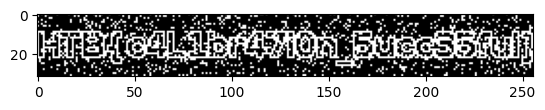

In [35]:
plt.imshow(np.array(result).reshape((32, 256)), cmap="gray")
plt.show()